In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

''' inputs '''
T=3.0 # horizon length 
N=1 # number of cars 
u_max=1.0 # free flow speed
rho_jam=1.0 # jam density
L=N # road length
CFL=0.75    # CFL<1
costf="LWR"

''' functions '''
def U(rho): # Greenshields desired speed
    return u_max*(1-rho/rho_jam)

def f_mfg(u,r):
    if costf=="LWR":
        return 0.5*((U(r)-u)**2) # MFG-LWR
    elif costf=="Sep":
        return 0.5*((u/u_max)**2)-(u/u_max)+(r/rho_jam) # MFG-Separable
    elif costf=="NonSep":
        return 0.5*((u/u_max)**2)-(u/u_max)+((u*r)/(u_max*rho_jam)) # MFG-NonSeparable

def f_star_p(p,r): # 0<=u<=u_max
    if costf=="LWR":
        return U(r)-p # MFG-LWR
    elif costf=="Sep":
        return max(min(u_max*(1-p*u_max),u_max),0) # MFG-Separable
    elif costf=="NonSep":
        return max(min(u_max*(1-r/rho_jam-u_max*p),u_max),0) # MFG-NonSeparable
    
def f_star(p,r): # p=Vx
    if costf=="LWR":
        return -0.5*(p**2)+U(r)*p # MFG-LWR
    elif costf=="Sep":
        return f_star_p(p,r)*p+f_mfg(f_star_p(p,r),r) # MFG-Separable
    elif costf=="NonSep":
        return f_star_p(p,r)*p+f_mfg(f_star_p(p,r),r) # MFG-NonSeparable

def solution(sol,rho,u,V,Q):
    for j in range(1,Nx+1):
        for n in range(0,Nt):
            rho[j,n]=sol[(j-1)*(Nt+1)+n]
            u[j,n]=sol[(Nt+1)*Nx+(j-1)*Nt+n]
            V[j,n]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
            Q[j,n]=rho[j,n]*u[j,n]
        rho[j,Nt]=sol[(j-1)*(Nt+1)+Nt]
        V[j,Nt]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+Nt]
    for n in range(0,Nt+1): # periodic boundary conditions
        rho[0,n]=rho[Nx,n]
        V[0,n]=V[Nx,n]
    for n in range(0,Nt):
        u[0,n]=f_star_p(V[0,n+1]/dx,rho[0,n])
        Q[0,n]=rho[0,n]*u[0,n]
#     print("rho=",rho)
#     print("u=",u)
#     print("V=",V)
    return 0

def solution2(sol,rho,u,V,Q):
    for j in range(1,Nx+1):
        for n in range(0,int(Nt/2)):
            rho[j,n]=sol[(j-1)*(Nt+1)+n]
            u[j,n]=sol[(Nt+1)*Nx+(j-1)*Nt+n]
            V[j,n]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+n]
            Q[j,n]=rho[j,n]*u[j,n]
        rho[j,int(Nt/2)]=sol[(j-1)*(Nt+1)+int(Nt/2)]
        V[j,int(Nt/2)]=sol[(2*Nt+1)*Nx+(j-1)*(Nt+1)+int(Nt/2)]
    for n in range(0,int(Nt/2)+1): # periodic boundary conditions
        rho[0,n]=rho[Nx,n]
        V[0,n]=V[Nx,n]
    for n in range(0,int(Nt/2)):
        u[0,n]=f_star_p(V[0,n+1]/dx,rho[0,n])
        Q[0,n]=rho[0,n]*u[0,n]
#     print("rho=",rho)
#     print("u=",u)
#     print("V=",V)
    return 0


def convergence(guess,sol,o):
    rho=np.zeros((Nx+1,Nt+1))
    u=np.zeros((Nx+1,Nt))
    V=np.zeros((Nx+1,Nt+1))
    Q=np.zeros((Nx+1,Nt))
    solution2(guess,rho,u,V,Q)
    rho_mfg=np.zeros((Nx+1,Nt+1))
    u_mfg=np.zeros((Nx+1,Nt))
    V_mfg=np.zeros((Nx+1,Nt+1))
    Q_mfg=np.zeros((Nx+1,Nt))
    solution2(sol,rho_mfg,u_mfg,V_mfg,Q_mfg)
    error=np.linalg.norm(rho_mfg-rho,ord=o)/np.linalg.norm(rho_mfg,ord=o)+np.linalg.norm(u_mfg-u,ord=o)/np.linalg.norm(u_mfg,ord=o)
#     error=np.linalg.norm(rho_mfg-rho,ord=o)+np.linalg.norm(u_mfg-u,ord=o)
    return error

def plotting(text,t,x,rho,u,V,Q,Nx_list,Error_list,fig1,fig2):
    tt, xx = np.meshgrid(t, x)
    fig = plt.figure(figsize=(6, 5), dpi=100)
    ax = fig.gca(projection='3d')
    ax.plot_surface(xx, tt, rho, cmap=cm.viridis)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('density')
    ax.invert_xaxis()
#     ax.text2D(0.05, 0.95, text, transform=ax.transAxes)
#     plt.savefig(fig1)

    plt.figure(figsize=(13, 8))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
    plt.subplot(2,3,1)
    plt.plot(x,rho[:,0],'b',label='density')
    plt.plot(x,u[:,0],'g',label='speed')
    plt.plot(x,V[:,0],'r',label='Optimal cost')
#     plt.legend()
    plt.grid()
    plt.title("t=0.0")
    plt.xlabel('x')
    plt.subplot(2,3,2)
    plt.plot(x,rho[:,int(Nt/3)],'b',label='density')
    plt.plot(x,u[:,int(Nt/3)],'g',label='speed')
    plt.plot(x,V[:,int(Nt/3)],'r',label='Optimal cost')
    plt.grid()
#     plt.legend()
    plt.title("t={t}".format(t=round(t[int(Nt/3)],3)))
    plt.xlabel('x')
    plt.subplot(2,3,3)
#     plt.plot(x,rho[:,int(2*Nt/3)],'b',label='density')
#     plt.plot(x,u[:,int(2*Nt/3)],'g',label='speed')
#     plt.plot(x,V[:,int(2*Nt/3)],'r',label='Optimal cost')
    plt.plot(x,rho[:,int(Nt/2)],'b',label='density')
    plt.plot(x,u[:,int(Nt/2)],'g',label='speed')
    plt.plot(x,V[:,int(Nt/2)],'r',label='Optimal cost')
    plt.grid()
    plt.legend()
#     plt.title("t={t}".format(t=round(t[int(2*Nt/3)],3)))
    plt.title("t={t}, T={T}".format(t=round(t[int(Nt/2)],3),T=T))
    plt.xlabel('x')
    plt.subplot(2,3,4)
    plt.scatter(rho[:,0],Q[:,0],s=10,label='flow-density')
    plt.xlabel('density')
    plt.ylabel('Flow')
    plt.grid()
    plt.title("Fundamental diagram (t=0)")
    plt.subplot(2,3,5)
    plt.scatter(rho[:,int(Nt/3)],Q[:,int(Nt/3)],s=10,label='flow-density')
#     plt.plot(rho[:,Nt-1],Q[:,Nt-1],label='flow-density')
    plt.xlabel('density')
#     plt.ylabel('Flow')
    plt.grid()
    plt.title("Fundamental diagram (t={t})".format(t=round(t[int(Nt/3)],3)))
    plt.subplot(2,3,6)
#     plt.scatter(rho[:,int(Nt/2)],Q[:,int(Nt/2)],s=10,label='flow-density')
    plt.scatter(rho[:,int(Nt/2)],Q[:,int(Nt/2)],s=10,label='flow-density')
    plt.xlabel('density')
#     plt.ylabel('Flow')
    plt.grid()
    plt.title("Fundamental diagram (t={t})".format(t=round(t[int(Nt/2)],3)))
#     plt.subplot(2,3,5)
    plt.figure()
    plt.plot(Nx_list,Error_list)
    plt.xlabel('Spatial grid size')
    plt.ylabel('error')
    plt.grid()
    plt.title("convergence of solution algorithm")
#     plt.savefig(fig2)
    return 0


dx=0.0333, dt=0.025
Nx=30, Nt=120
dx=0.0167, dt=0.0125
Nx=60, Nt=240
dx=0.0083, dt=0.0063
Nx=120, Nt=480
dx=0.0042, dt=0.0031
Nx=240, Nt=960


0

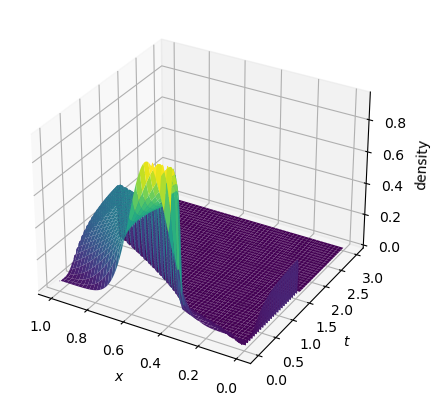

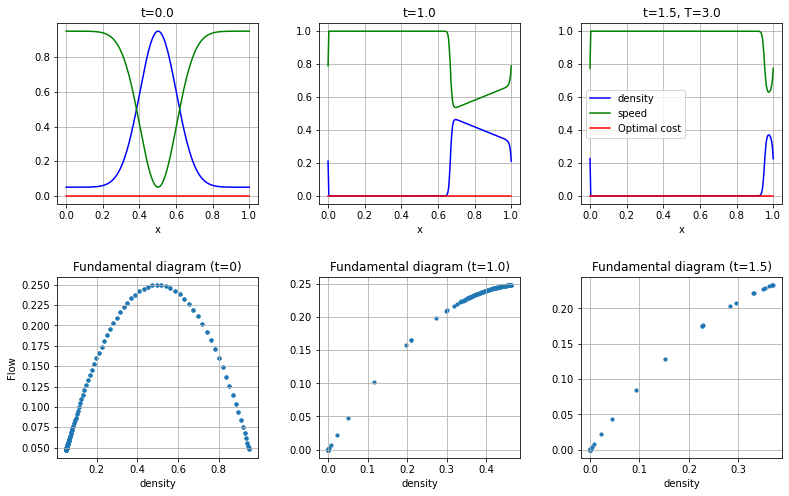

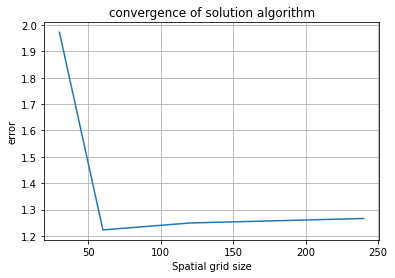

In [2]:
Error_list=[]
Nx_list=[]
""" solve in coarse grid """
Nx=30; Nt=120 # spatial-temporal grid sizes 
dx=L/Nx # spatial step size
dt=min(T/Nt,(CFL*dx)/u_max) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,4),dt=round(dt,4)))
x=np.linspace(0,L,Nx+1)
# t=np.linspace(0,T,Nt+1)
t=np.arange(0,T,dt)
Nt=len(t)
print('Nx={Nx}, Nt={Nt}'.format(Nx=Nx,Nt=Nt))
guess0 = np.zeros(3*Nt*Nx+2*Nx)
sol0=np.loadtxt('Sol0_LWR_T3_N1.dat')
error0=convergence(guess0,sol0,1)
Error_list.append(error0)
Nx_list.append(Nx)

""" solve in finer grid 1 """
Nx=2*Nx; Ntt=2*Nt
dx=L/Nx # spatial step size
dt=min(T/Ntt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,4),dt=round(dt,4)))
x=np.linspace(0,L,Nx+1)
t=np.arange(0,T,dt)
Nt=int(len(t)/2)
Nt=2*Nt
print('Nx={Nx}, Nt={Nt}'.format(Nx=Nx,Nt=Nt))
guess1=np.loadtxt('Guess1_LWR_T3_N1.dat')
sol1=np.loadtxt('Sol1_LWR_T3_N1.dat')
error1=convergence(guess1,sol1,1)
Error_list.append(error1)
Nx_list.append(Nx)

""" solve in finer grid 2 """
Nx=2*Nx; Ntt=2*Nt
dx=L/Nx # spatial step size
dt=min(T/Ntt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,4),dt=round(dt,4)))
x=np.linspace(0,L,Nx+1)
t=np.arange(0,T,dt)
Nt=int(len(t)/2)
Nt=2*Nt
print('Nx={Nx}, Nt={Nt}'.format(Nx=Nx,Nt=Nt))
guess2=np.loadtxt('Guess2_LWR_T3_N1.dat')
sol2=np.loadtxt('Sol2_LWR_T3_N1.dat')
error2=convergence(guess2,sol2,1)
Error_list.append(error2)
Nx_list.append(Nx)

""" solve in finer grid 3 """
Nx=2*Nx; Ntt=2*Nt
dx=L/Nx # spatial step size
dt=min(T/Ntt,CFL*dx/abs(u_max)) # temporal step size
print('dx={dx}, dt={dt}'.format(dx=round(dx,4),dt=round(dt,4)))
x=np.linspace(0,L,Nx+1)
t=np.arange(0,T,dt)
Nt=int(len(t)/2)
Nt=2*Nt
print('Nx={Nx}, Nt={Nt}'.format(Nx=Nx,Nt=Nt))
guess3=np.loadtxt('Guess3_LWR_T3_N1.dat')
sol3=np.loadtxt('Sol3_LWR_T3_N1.dat')
error3=convergence(guess3,sol3,1)
Error_list.append(error3)
Nx_list.append(Nx)

""" Solutions """
rho_mfg=np.zeros((Nx+1,Nt+1))
u_mfg=np.zeros((Nx+1,Nt))
V_mfg=np.zeros((Nx+1,Nt+1))
Q_mfg=np.zeros((Nx+1,Nt))
solution(sol3,rho_mfg,u_mfg,V_mfg,Q_mfg)
x_mfg=np.linspace(0,L,Nx+1)
t_mfg=np.linspace(0,T,Nt+1)

""" Plots """
title1="\n Non Viscous MFG-Separable"
fig1= 'mfg1_LWR_T3_N1_reg.png'
fig2= 'mfg2_LWR_T3_N1_reg.png'
plotting(title1,t_mfg,x_mfg,rho_mfg,u_mfg,V_mfg,Q_mfg,Nx_list,Error_list,fig1,fig2)